<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>

<h1 align="center"><font size="6">Telecom Churn Prediction Analysis</font></h1> 
<h2 align="center"><font size="4">Supervised Machine Learning: Classification - Final Assignment</font></h2>

### About the data

This notebook will consist of experimental classification modelling for a telecom churn dataset. You can find the dataset online [here](https://www.kaggle.com/datasets/jpacse/datasets-for-churn-telecom?select=cell2cellholdout.csv). <br><br>

There are no clear definitions for the features in the dataset, though for the most we can detect what each feature pertains to from the title.<br>
There are features pertaining to customer usage behaviour such as data allowance, usage in minutes and roaming calls. It also includes customer segment such as age, income group and credit rating. 

### Objective

The objective of the analysis is to use customer segmentation and behaviour data to predict whether or not a customer is going to churn from the company. The priority in the analysis is predicting customers who churn i.e `class = 1`. This is because there is greater cost to the company in failing to detect a customer churn event than incorrectly predicting a false positive churn event. It is crucial that by the end of the analysis that we choose a best model and recommend some improvements for future iterations of our chosen model.

## Table of Contents

1. [Data Pre-processing](#Data-Pre-processing)
2. [Tackling Imbalanced Data](#Tackling-Imbalanced-Data)
3. [Random Forest](#Random-Forest)
4. [Support Vector Machine](#Support-Vector-Machine)
5. [Logistic Regression](#Logistic-Regression)
6. [Choosing our Best Model](#Choosing-our-Best-Model)

### Import the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import sklearn as skl
import seaborn as sns

from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, precision_recall_fscore_support, roc_auc_score, recall_score, precision_score

### Create Helper Functions

In [2]:
# calculate accuracy of the training and testing data given a model
def get_accuracy(X_train, X_test, y_train, y_test, model):
    return  {"test Accuracy":metrics.accuracy_score(y_test, model.predict(X_test)),"train Accuracy": metrics.accuracy_score(y_train, model.predict(X_train))}

In [3]:
def evaluate(yt, yp, eval_type):
    results_pos = {}
    results_pos['type'] = eval_type
    # Accuracy
    results_pos['accuracy'] = accuracy_score(yt, yp)
    # Precision, recall, Fscore
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp, beta=5, pos_label=1, average='binary')
    results_pos['recall'] = recall
    # AUC
    results_pos['auc'] = roc_auc_score(yt, yp)
    # Precision
    results_pos['precision'] = precision
    # Fscore
    results_pos['fscore'] = f_beta
    return results_pos

In [4]:
def get_correlation(X_test, y_test,models):
    #This function calculates the average correlation between predictors  
    n_estimators=len(models.estimators_)
    prediction=np.zeros((y_test.shape[0],n_estimators))
    predictions=pd.DataFrame({'estimator '+str(n+1):[] for n in range(n_estimators)})
    
    for key,model in zip(predictions.keys(),models.estimators_):
        predictions[key]=model.predict(X_test.to_numpy())
    
    corr=predictions.corr()
    print("Average correlation between predictors: ", corr.mean().mean()-1/n_estimators)
    return corr

In [5]:
def get_confusion_matrix(yt, yp, title):
    cf = confusion_matrix(yt, yp)
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(cf, annot=True, linecolor='black', fmt='g', ax=ax, cmap='BuPu')
    plt.title(title)
    plt.xlabel('Y predict')
    plt.ylabel('Y test')
    plt.show()

## Data Pre-processing 

The pre-processing for this project has been done in a separate notebook. You can find that notebook here:<br>
To summarise the data cleaning steps taken:
* Handled <font color="green">**missing data**</font> by either dropping columns or rows or replacing with mean or median 
* Split the data into numerical, binary, categorical and ordinal features and performed the appropriate <font color="green">**encoding**</font> method:
    * binary - sklearn.preprocessing.LabelBinarizer()
    * categorical - pd.get_dummies()
    * ordinal - sklearn.preprocessing.LabelEncoder()
* Scaled the data using <font color="green">**Robust Scaling**</font> using sklearn.preprocessing.RobustScaler() class
    * set the quartile range to be p20 and p80 instead of the default p25 and p75 in order to be slightly more generous to perceived outliers and more reprensentative of the dataset which has high outlier presence. 

### Import Data

In [6]:
df = pd.read_pickle("churn dataset transformed.pkl")
df.head()

,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,...,BuysViaMailOrder,RespondsToMailOffers,RetentionCalls,RetentionOffersAccepted,ReferralsMadeBySubscriber,IncomeGroup,AdjustmentsToCreditRating,MadeCallToRetentionTeam,CreditRating,AgeBand
0,1,-0.510860,-0.205307,-0.766667,0.000000,-0.052632,0.0,-0.722488,-1.246667,-0.255556,...,1.0,1.0,1.0,0.0,0.0,-0.142857,0.0,1.0,-0.5,0.666667
1,1,-0.657268,-0.497207,-0.933333,-0.201613,-0.052632,0.0,0.009569,0.020000,-0.300000,...,1.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,-0.333333
2,0,-0.218463,-0.500000,-0.233333,-0.201613,-0.052632,0.0,0.019139,0.020000,-0.333333,...,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.5,1.000000
3,0,0.706349,1.321229,1.000000,0.798387,-0.052632,0.0,0.779904,0.560000,5.444444,...,1.0,1.0,0.0,0.0,0.0,0.142857,0.0,0.0,1.0,-0.333333
4,1,-0.654135,-0.511173,-0.933333,-0.201613,-0.052632,0.0,0.028708,0.006667,-0.333333,...,1.0,1.0,0.0,0.0,0.0,0.571429,1.0,0.0,-0.5,0.666667


## Tackling Imbalanced Data

<Axes: xlabel='Churn'>

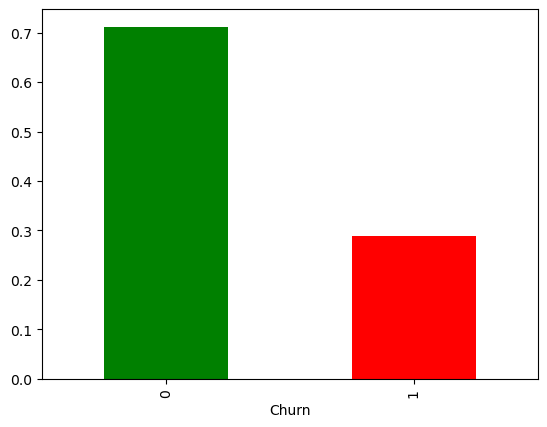

In [7]:
# checking to see if our target variable is imbalanced
df.Churn.value_counts(normalize=True).plot.bar(color=['green','red'])

On the whole it appears that our dataset is quite imbalanced in favour of non-churners. So we'll have to address this within each of our modelling attempts.

Because our dataset is complex, with 100 features, and has a high prevalence of outliers, we will choose `RandomForest`, `KNN` and `SVM` as our base learners. 

In [8]:
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.3,stratify=y)

In [9]:
from sklearn.ensemble import RandomForestClassifier

In [10]:
# Grid search hyperparameters for a random forest model
# params_grid = {
#     'max_depth': [5, 10, 15, 20],
#     'n_estimators': [25, 50, 100],
#     'min_samples_split': [2, 5],
#     'class_weight': [{0:0.1, 1:0.9}, {0:0.2, 1:0.8}, {0:0.3, 1:0.7}],
#     'max_features':["sqrt", "log2"]
#     }
# # initialise basic random forest model
# rf_model = RandomForestClassifier(random_state=123)
# grid_search = GridSearchCV(estimator = rf_model, 
#                            param_grid = params_grid, 
#                            scoring='f1',
#                            cv=3, verbose=1, n_jobs=-1, error_score='raise')
# grid_search.fit(X_train, y_train)

In [11]:
# import pickle
# pickle.dump(grid_search, open("rf_grid_search.pkl", 'wb'))

In [12]:
rf_grid_search = pd.read_pickle('rf_grid_search.pkl')

In [13]:
print(rf_grid_search.best_params_)
print(rf_grid_search.best_estimator_)
print(rf_grid_search.best_score_)
print(get_accuracy(X_train, X_test, y_train, y_test, rf_grid_search.best_estimator_))

{'class_weight': {0: 0.2, 1: 0.8}, 'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 100}
RandomForestClassifier(class_weight={0: 0.2, 1: 0.8}, max_depth=10,
                       max_features='log2', min_samples_split=5,
                       random_state=123)
0.48546305830448705
{'test Accuracy': 0.47224761656001046, 'train Accuracy': 0.522025075562521}


While our f1score on both the training set and test set is relative low, we somewhat expect this due to the imbalanced nature of the dataset. We'll experiment with different sampling techniques using our random forest model and the best parameters learned from the Grid Search.

### Original

In [14]:
rf_model = RandomForestClassifier(max_depth=10, max_features='log2', min_samples_split=5, n_estimators=100, random_state=123)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

In [15]:
results = evaluate(y_test, rf_preds, "Original")
results_df = pd.DataFrame(results.items()).T
new_headers = results_df.iloc[0]
results_df = results_df.iloc[1:]
results_df.columns = new_headers
results_df

,type,accuracy,recall,auc,precision,fscore
1,Original,0.71575,0.03671,0.513676,0.613636,0.038087


As expected, our basic random forest model without the class reweighting performs poorly on almost all metrics.

### Class Re-weighting

In [16]:
rf_crw = rf_grid_search.best_estimator_
rf_crw.fit(X_train, y_train)
rf_crw_preds = rf_crw.predict(X_test)

In [17]:
results = evaluate(y_test, rf_crw_preds, "Class Re-weighting")
new_row_df = pd.DataFrame.from_dict([results])
results_df = pd.concat([results_df, new_row_df], axis=0)
results_df

,type,accuracy,recall,auc,precision,fscore
1,Original,0.71575,0.03671,0.513676,0.613636,0.038087
0,Class Re-weighting,0.472248,0.876501,0.592548,0.339149,0.826156


By applying `Class Re-weighting` we have greatly improved crucial metrics such as recall, auc and fscore. Our accuracy has gone down a little bit but arguably the most important thing is that we accurately identify customers who are going to churn so we can target them with some promotions. If current customers get promotions to upgrade mistakenly it's not the end of the world.

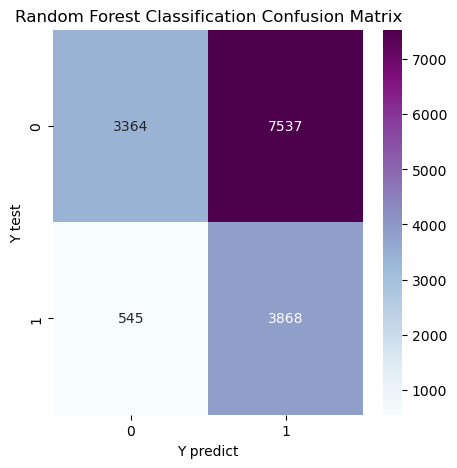

In [18]:
rf_crw_cm = confusion_matrix(y_test, rf_crw_preds)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(rf_crw_cm, annot=True, linecolor='black', fmt='g', ax=ax, cmap='BuPu')
plt.title('Random Forest Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

The model appears to be incorrectly predicting Churn events. This is surprising as we would expect the other way around since our majority class is 0 / "No Churn." We will assess the model performance after our resampling attemps.

### SMOTE

<Axes: xlabel='Churn'>

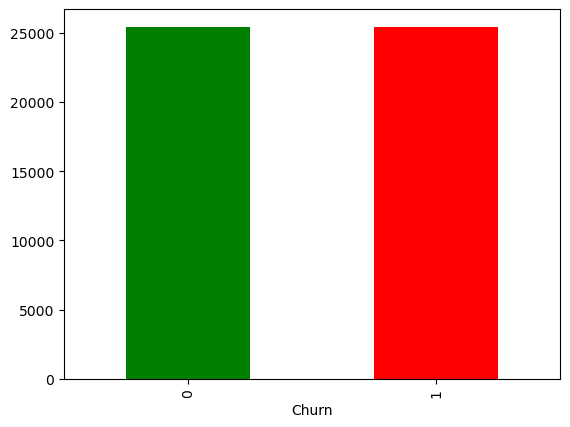

In [19]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
smote_sampler = SMOTE(random_state=123)

# Resample training data using SMOTE
X_smo, y_smo = smote_sampler.fit_resample(X_train, y_train)
# Visualize classes
y_smo.value_counts().plot.bar(color=['green', 'red'])

In [20]:
rf_smote = rf_grid_search.best_estimator_
rf_smote.fit(X_smo, y_smo)
rf_smote_preds = rf_smote.predict(X_test)

KeyboardInterrupt: 

In [ ]:
results = evaluate(y_test, rf_smote_preds, "SMOTE")
new_row_df = pd.DataFrame.from_dict([results])
results_df = pd.concat([results_df, new_row_df], axis=0)
results_df

,type,accuracy,recall,auc,precision,fscore
1,Original,0.71575,0.03671,0.513676,0.613636,0.038087
0,Class Re-weighting,0.472248,0.876501,0.592548,0.339149,0.826156
0,SMOTE,0.367507,0.956492,0.542781,0.307765,0.884763


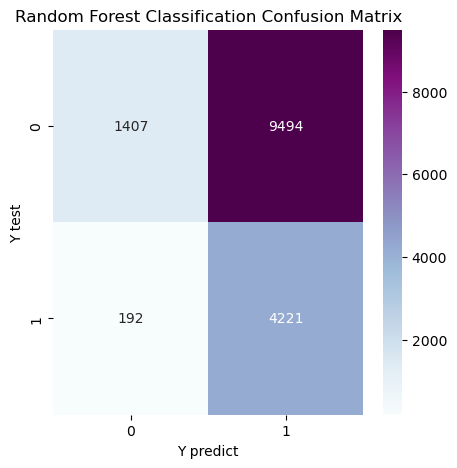

In [ ]:
rf_smote_cm = confusion_matrix(y_test, rf_smote_preds)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(rf_smote_cm, annot=True, linecolor='black', fmt='g', ax=ax, cmap='BuPu')
plt.title('Random Forest Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

The SMOTE method has marginally improved our recall and fscore. We expect this as by oversampling we have increased the weighting of our positive class and thus the model predicts more positive instances. Again though we have a large number of false positives, indicated by our low precision score again.

### Undersampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
under_sampler = RandomUnderSampler(random_state=123)
X_under, y_under = under_sampler.fit_resample(X_train, y_train)

In [ ]:
rf_us = rf_grid_search.best_estimator_
rf_us.fit(X_under, y_under)
rf_us_preds = rf_us.predict(X_test)

In [ ]:
results = evaluate(y_test, rf_us_preds, 'Undersampling')
new_row_df = pd.DataFrame.from_dict([results])
results_df = pd.concat([results_df, new_row_df], axis=0)
results_df

,type,accuracy,recall,auc,precision,fscore
1,Original,0.71575,0.03671,0.513676,0.613636,0.038087
0,Class Re-weighting,0.472248,0.876501,0.592548,0.339149,0.826156
0,SMOTE,0.367507,0.956492,0.542781,0.307765,0.884763
0,Undersampling,0.308998,0.992749,0.512474,0.293416,0.909386


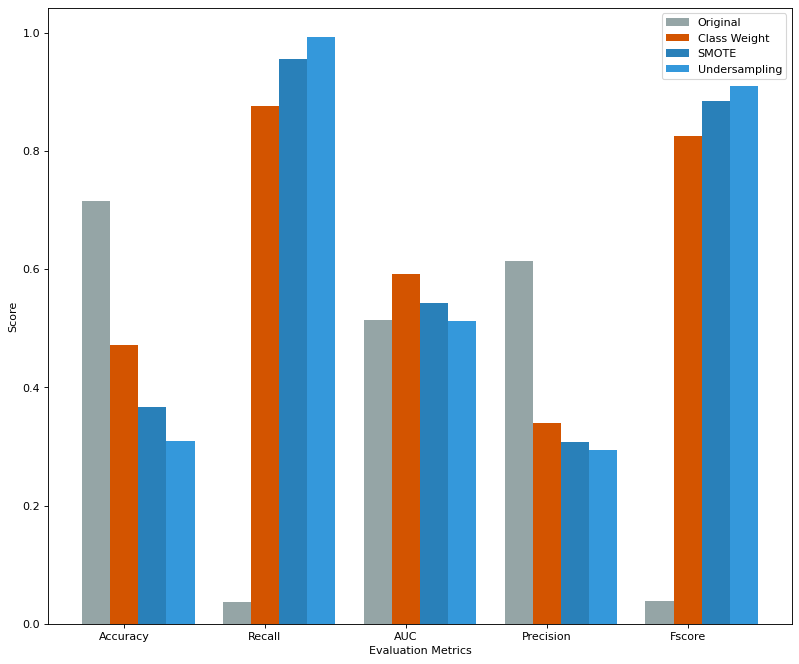

In [ ]:
x = np.arange(5)
original = results_df.iloc[0, 1:].values
class_weight = results_df.iloc[1, 1:].values
smote = results_df.iloc[2, 1:].values
under = results_df.iloc[3, 1:].values

figure(figsize=(12, 10), dpi=80)
plt.bar(x-0.2, original, 0.2, color='#95a5a6')
plt.bar(x, class_weight, 0.2, color='#d35400')
plt.bar(x+0.2, smote, 0.2, color='#2980b9')
plt.bar(x+0.4, under, 0.2, color='#3498db')
plt.xticks(x, ['Accuracy', 'Recall', 'AUC', 'Precision', 'Fscore'])
plt.xlabel("Evaluation Metrics")
plt.ylabel("Score")
plt.legend(["Original", "Class Weight", "SMOTE", "Undersampling"])
plt.show()

**Summary**<br>
* `Original` -  While our original model boasts the best accuracy and precision by far, the recall is concerningly low. This isn't surprising since our dataset is highly imbalanced in favor of the negative class. Therefore, our basic model has generated predictions on the bias of the negative class, at the cost of the positives.
* `Class Re-weighting` - This is most likely our most well-rounded model with a strong recall and fscore score and the best precision of all but the basic model.
* `SMOTE` - As expected, our SMOTE model greatly improves the fscore and recall on our class re-weighting model since we have increased the weighting of our positive class and thus the model predicts more positive instances. 
* `Undersampling` - While our undersampling model shows pretty good scores across the board, of course this reduces the number of records in this dataset and so generally undersampling is to be avoided.<br><br>
We'll go for **class re-weighting** to address the imbalanced nature of our dataset!

## Random Forest

We have already generated our best random forest model so we will initialise it specifying each parameters for clarity.

In [ ]:
rf_grid_search.best_estimator_

RandomForestClassifier(class_weight={0: 0.2, 1: 0.8}, max_depth=10,
                       max_features='log2', min_samples_split=5,
                       random_state=123)

In [ ]:
rf = RandomForestClassifier(class_weight={0: 0.2, 1: 0.8}, max_depth=10,
                       max_features='log2', min_samples_split=5, random_state=123)

---

## Support Vector Machine

In [ ]:
from sklearn.svm import SVC

In [ ]:
# re-define evaluate_metrics function
def evaluate_metrics(yt, yp):
    results_pos = {}
    results_pos['accuracy'] = accuracy_score(yt, yp)
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp) # average='binary'
    results_pos['recall'] = recall
    results_pos['precision'] = precision
    results_pos['f1score'] = f_beta
    return results_pos

### Create data in higher-dimensional space

SVMs with RBF Kernels are very slow to train with lots of features of data. In practice, one does not need to be very rigorous to achieve good enough results, so we can construct an approximate kernel mapping and that's usually going to be good enough. Our goal is to buy a lot of computational ease and time in exchange for a minimal drop-off in performance.

#### Run kernel approximation and perform LinearSVC

With this technique, we can derive new features without having to create new features for every single one of our data points because again now we're working with a ton more data, we come up with an approximation that will map to higher dimensional space and then come up with our linear classifier.

In [ ]:
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDClassifier

kwargs = {'kernel':'rbf'}
nystroem = Nystroem(**kwargs, n_components=500, random_state=123)
sgd = SGDClassifier()

In [ ]:
# Transform the training data
X_train_transformed = nystroem.fit_transform(X_train)
# Transform the testing data using the same transformation
X_test_transformed = nystroem.transform(X_test)
# Train the SGDClassifier on the transformed training data and generate predictions
sgd.fit(X_train_transformed, y_train)
sgd_y_preds = sgd.predict(X_test_transformed)

Interpret results and visualise predictions with confusion matrix

In [ ]:
my_dict = evaluate_metrics(y_test, sgd_y_preds)
{k: tuple(v.ravel()) for k,v in my_dict.items()}

{'accuracy': (0.7118323103042967,),
 'recall': (0.9999082652967618, 0.00022660321776569228),
 'precision': (0.7118599791013585, 0.5),
 'f1score': (0.8316484187235342, 0.00045300113250283127)}

We achieved a 71% accuracy score from this run but our recall, precision and f1score are quite low for our predictor class `class = 1`.

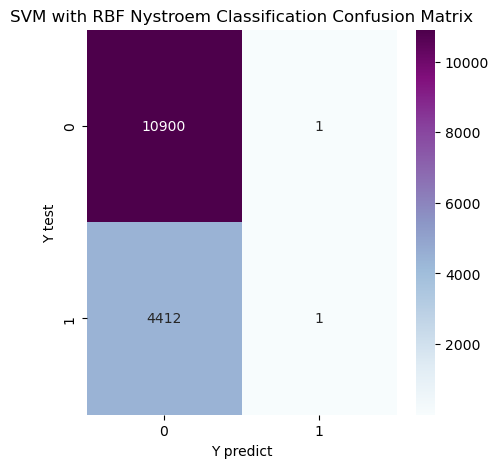

In [ ]:
get_confusion_matrix(y_test, sgd_y_preds, 'SVM with RBF Nystroem Classification Confusion Matrix')

As we can see, our 71% accuracy score is achieved from correctly predicting the majority class 0. We will re-run the SVM mdoel after performing some resampling to see if we can produce better predictions.

We'll create a tuning dataframe with different kernels, degree(polynomial only), n_components and gamma parameters to see if we can find on optimal combination for our analysis.<br>
For now we'll use SMOTE as the technique to resample our data for this tuning exercise. We can experiment with other resampling techniques once we have found our bets model.

#### Paramater Tuning with SMOTE Resampling

In [ ]:
smote_sampler = SMOTE(random_state=123)
X_smo, y_smo = smote_sampler.fit_resample(X_train, y_train)
print(len(X_smo))
print(len(y_smo))

50870
50870


In [ ]:
from itertools import product, combinations

In [ ]:
param_grid = {
    'nystroem__kernel': ['rbf', 'poly', 'sigmoid'],
    'nystroem__n_components': [100, 300, 500, 1000],
    'nystroem__gamma': [0.5, 1.0, 2.0],
    'nystroem__degree': [2, 3, 4]
}
param_grid_combined = list(product(*param_grid.values()))
svm_tuning_df = pd.DataFrame(columns=['kernel','n_components','gamma','degree'],data=param_grid_combined)
svm_tuning_df.head()

,kernel,n_components,gamma,degree
0,rbf,100,0.5,2
1,rbf,100,0.5,3
2,rbf,100,0.5,4
3,rbf,100,1.0,2
4,rbf,100,1.0,3


*It's worth mentioning that the **degree** parameter is ignored for all kernel types except polynomial.*

In [ ]:
# svm_base_df = pd.DataFrame(columns=['params','accuracy','recall','precision','f1score','kernel'])
# for id, row in svm_tuning_df.iterrows():
#     kernel_val = row[0]
#     n_comps_val = row[1]
#     gamma_val = row[2]
#     degree_val = row[3]

#     nystroem_model = Nystroem(kernel=kernel_val, n_components=n_comps_val, gamma=gamma_val, degree=degree_val, random_state=123)
#     sgd_classifier = SGDClassifier()

#     X_smo_transformed = nystroem_model.fit_transform(X=X_smo)
#     X_test_transformed = nystroem_model.fit_transform(X=X_test)
    
#     sgd_classifier.fit(X_smo_transformed, y_smo)
#     sgd_y_preds = sgd_classifier.predict(X_test_transformed)

#     scores = evaluate_metrics(y_test, sgd_y_preds)
#     results_df = pd.DataFrame.from_dict(scores).reset_index().rename(columns={'index':'params'})
#     results_df.iloc[0,0] = f"{kernel_val + '_' + str(n_comps_val) + '_' + str(gamma_val) + '_' + str(degree_val) + '_' + str(results_df.iloc[0,0])}"
#     results_df.iloc[1,0] = f"{kernel_val + '_' + str(n_comps_val) + '_' + str(gamma_val) + '_' + str(degree_val) + '_' + str(results_df.iloc[1,0])}"
#     results_df['kernel'] = kernel_val

#     svm_base_df = pd.concat([svm_base_df, results_df], axis=0)

In [ ]:
# import pickle
# pickle.dump(svm_base_df, open('svm_tuning_results_df.pkl', 'wb'))

# import tuning base df created from code above
svm_base_df = pd.read_pickle('svm_tuning_results_df.pkl')

*Interpreting Results*

In [ ]:
svm_tuning_results_df = svm_base_df.copy()
svm_tuning_results_df = svm_tuning_results_df.reset_index().rename(columns={'index':'class'})
svm_tuning_results_df.head()

,class,params,accuracy,recall,precision,f1score,kernel
0,0,rbf_100_0.5_2_0,0.682643,0.930649,0.711980,0.806759,rbf
1,1,rbf_100_0.5_2_1,0.682643,0.070020,0.290141,0.112815,rbf
2,0,rbf_100_0.5_3_0,0.691328,0.950005,0.712340,0.814183,rbf
3,1,rbf_100_0.5_3_1,0.691328,0.052345,0.297680,0.089034,rbf
4,0,rbf_100_0.5_4_0,0.692373,0.952573,0.712306,0.815103,rbf


In [ ]:
svm_tuning_results_df.groupby(by=['kernel','class']).describe().T.apply(lambda x:round(x,2).astype(np.float64))

kernel            poly           rbf        sigmoid       
class                0      1      0      1       0      1
accuracy  count  36.00  36.00  36.00  36.00   36.00  36.00
          mean    0.47   0.47   0.66   0.66    0.45   0.45
          std     0.05   0.05   0.11   0.11    0.02   0.02
          min     0.39   0.39   0.29   0.29    0.42   0.42
          25%     0.42   0.42   0.67   0.67    0.44   0.44
          50%     0.46   0.46   0.70   0.70    0.45   0.45
          75%     0.51   0.51   0.71   0.71    0.46   0.46
          max     0.55   0.55   0.71   0.71    0.52   0.52
recall    count  36.00  36.00  36.00  36.00   36.00  36.00
          mean    0.43   0.55   0.87   0.13    0.40   0.59
          std     0.12   0.13   0.27   0.27    0.05   0.04
          min     0.25   0.34   0.00   0.00    0.32   0.48
          25%     0.32   0.43   0.89   0.01    0.37   0.57
          50%     0.43   0.55   0.98   0.02    0.39   0.60
          75%     0.53   0.68   0.99   0.12    0.42   0.63
          max     0.63   0.76   1.00   1.00    0.53   0.66
precision count  36.00  36.00  36.00  36.00   36.00  36.00
          mean    0.71   0.28   0.69   0.28    0.71   0.29
          std     0.01   0.01   0.12   0.03    0.01   0.01
          min     0.69   0.26   0.00   0.16    0.70   0.28
          25%     0.70   0.27   0.71   0.26    0.70   0.28
          50%     0.70   0.28   0.71   0.29    0.70   0.28
          75%     0.71   0.29   0.71   0.29    0.71   0.29
          max     0.72   0.29   0.72   0.33    0.73   0.30
f1score   count  36.00  36.00  36.00  36.00   36.00  36.00
          mean    0.53   0.37   0.75   0.10    0.51   0.38
          std     0.09   0.04   0.22   0.13    0.04   0.01
          min     0.37   0.30   0.00   0.00    0.43   0.37
          25%     0.44   0.33   0.79   0.01    0.49   0.38
          50%     0.53   0.37   0.83   0.03    0.50   0.38
          75%     0.60   0.40   0.83   0.17    0.53   0.39
          max     0.67   0.42   0.83   0.45    0.61   0.41

Polynomial models

In [ ]:
# model with highest recall for positive class
max_poly_recall = svm_tuning_results_df[(svm_tuning_results_df['kernel'] == 'poly')&(svm_tuning_results_df['class'] == 1)]['recall'].max()
max_poly_recall_index = svm_tuning_results_df[(svm_tuning_results_df['kernel'] == 'poly')&(svm_tuning_results_df['recall'] == max_poly_recall)].index[0]
svm_tuning_results_df.iloc[[max_poly_recall_index,max_poly_recall_index-1]]

,class,params,accuracy,recall,precision,f1score,kernel
109,1,poly_500_0.5_2_1,0.393366,0.756175,0.288893,0.418066,poly
108,0,poly_500_0.5_2_0,0.393366,0.246491,0.714058,0.366476,poly


In [ ]:
# model with highest precision for positive class
max_poly_precision = svm_tuning_results_df[(svm_tuning_results_df['kernel'] == 'poly')&(svm_tuning_results_df['class'] == 1)]['precision'].max()
max_poly_precision_index = svm_tuning_results_df[(svm_tuning_results_df['kernel'] == 'poly')&(svm_tuning_results_df['precision'] == max_poly_precision)].index[0]
svm_tuning_results_df.iloc[[max_poly_precision_index,max_poly_precision_index-1]]

,class,params,accuracy,recall,precision,f1score,kernel
77,1,poly_100_0.5_4_1,0.419159,0.716066,0.292538,0.41538,poly
76,0,poly_100_0.5_4_0,0.419159,0.298963,0.722296,0.42289,poly


In [ ]:
poly_best_model = {'kernel':'poly', 'n_components':100, 'gamma':0.5, 'degree':4}

RBF models

In [ ]:
rbf_max_recall_1_index = svm_tuning_results_df[(svm_tuning_results_df['kernel'] == 'rbf')&\
    (svm_tuning_results_df['recall']==1)&\
    (svm_tuning_results_df['class']==1)
    ].index[0]
svm_tuning_results_df.iloc[[rbf_max_recall_1_index, rbf_max_recall_1_index-1],0:]

,class,params,accuracy,recall,precision,f1score,kernel
15,1,rbf_100_2.0_3_1,0.288168,1.0,0.288168,0.447407,rbf
14,0,rbf_100_2.0_3_0,0.288168,0.0,0.000000,0.000000,rbf


It looks like for for rbf where we've achieved 100% recall for our positive class, we've achieved 0% for our negative class. We won't be able to run with this dynamic.

In [ ]:
svm_tuning_results_df[(svm_tuning_results_df['kernel'] == 'rbf')&\
    (svm_tuning_results_df['recall']!=1)&\
    (svm_tuning_results_df['class']==1)
].sort_values(by='recall',ascending=False).head()

,class,params,accuracy,recall,precision,f1score,kernel
31,1,rbf_300_2.0_2_1,0.290649,0.990483,0.287717,0.445907,rbf
71,1,rbf_1000_2.0_4_1,0.307954,0.934965,0.285793,0.437772,rbf
59,1,rbf_1000_0.5_4_1,0.613164,0.243145,0.293410,0.265923,rbf
57,1,rbf_1000_0.5_3_1,0.625637,0.203716,0.288326,0.238747,rbf
37,1,rbf_500_0.5_2_1,0.625506,0.202357,0.287323,0.237468,rbf


Only two models have a recall score not equal to one but higher than 0.5.

In [ ]:
rbf_indexes = list(svm_tuning_results_df[(svm_tuning_results_df['kernel'] == 'rbf')&\
    (svm_tuning_results_df['recall']!=1)&\
    (svm_tuning_results_df['class']==1)
].sort_values(by='recall',ascending=False).head(2).index)
rbf_indexes = list(np.array([[i, i-1] for i in rbf_indexes]).flatten())
svm_tuning_results_df.iloc[rbf_indexes, 0:]

,class,params,accuracy,recall,precision,f1score,kernel
31,1,rbf_300_2.0_2_1,0.290649,0.990483,0.287717,0.445907,rbf
30,0,rbf_300_2.0_2_0,0.290649,0.007339,0.655738,0.014515,rbf
71,1,rbf_1000_2.0_4_1,0.307954,0.934965,0.285793,0.437772,rbf
70,0,rbf_1000_2.0_4_0,0.307954,0.054123,0.672748,0.100187,rbf


rbf_1000_2.0_4 is probably a better model to select as the recall for our negative class is 5% higher than the other model. This si stillr eally low though and we probably shouldn't proceed with this.

In [ ]:
rbf_best_model = {'kernel':'rbf', 'n_components':1000, 'gamma':2.0}

Sigmoid models

In [ ]:
# model with highest recall for positive class
max_sigmoid_recall = svm_tuning_results_df[(svm_tuning_results_df['kernel'] == 'sigmoid')&(svm_tuning_results_df['class'] == 1)]['recall'].max()
max_sigmoid_recall_index = svm_tuning_results_df[(svm_tuning_results_df['kernel'] == 'sigmoid')&(svm_tuning_results_df['recall'] == max_sigmoid_recall)].index[0]
svm_tuning_results_df.iloc[[max_sigmoid_recall_index,max_sigmoid_recall_index-1]]

,class,params,accuracy,recall,precision,f1score,kernel
165,1,sigmoid_300_0.5_3_1,0.415829,0.663041,0.281753,0.395459,sigmoid
164,0,sigmoid_300_0.5_3_0,0.415829,0.315751,0.698316,0.434870,sigmoid


In [ ]:
# model with highest precision for positive class
max_sigmoid_precision = svm_tuning_results_df[(svm_tuning_results_df['kernel'] == 'sigmoid')&(svm_tuning_results_df['class'] == 1)]['precision'].max()
max_sigmoid_precision_index = svm_tuning_results_df[(svm_tuning_results_df['kernel'] == 'sigmoid')&(svm_tuning_results_df['precision'] == max_sigmoid_precision)].index[0]
svm_tuning_results_df.iloc[[max_sigmoid_precision_index,max_sigmoid_precision_index-1]]

,class,params,accuracy,recall,precision,f1score,kernel
145,1,sigmoid_100_0.5_2_1,0.482108,0.597779,0.299977,0.399485,sigmoid
144,0,sigmoid_100_0.5_2_0,0.482108,0.435281,0.727761,0.544745,sigmoid


For our sigmoid kernel models, the recall is slightly more balanced between our positive and negative classes. sigmoid_300_0.5 model is probably slightly better because it has a much higher recall for the positive class but only a slight drop off in the precision.

In [ ]:
sigmoid_best_model = {'kernel':'sigmoid', 'n_components':300, 'gamma':0.5}

Visualise best kernel models and choose best SVM kernel approximation model

In [ ]:
print(poly_best_model)
print(rbf_best_model)
print(sigmoid_best_model)

{'kernel': 'poly', 'n_components': 100, 'gamma': 0.5, 'degree': 4}
{'kernel': 'rbf', 'n_components': 1000, 'gamma': 2.0}
{'kernel': 'sigmoid', 'n_components': 300, 'gamma': 0.5}


In [ ]:
best_model_indexes = [144,145,70,71,76,77]
best_model_df = svm_tuning_results_df.iloc[best_model_indexes,0:]

In [ ]:
# remove degree parameter from irrelevant model names
best_model_df.iloc[0,1] = 'sigmoid_100_0.5_0'
best_model_df.iloc[1,1] = 'sigmoid_100_0.5_1'

best_model_df.iloc[2,1] = 'rbf_1000_2.0_0'
best_model_df.iloc[3,1] = 'rbf_1000_2.0_1'

best_model_df

,class,params,accuracy,recall,precision,f1score,kernel
144,0,sigmoid_100_0.5_0,0.482108,0.435281,0.727761,0.544745,sigmoid
145,1,sigmoid_100_0.5_1,0.482108,0.597779,0.299977,0.399485,sigmoid
70,0,rbf_1000_2.0_0,0.307954,0.054123,0.672748,0.100187,rbf
71,1,rbf_1000_2.0_1,0.307954,0.934965,0.285793,0.437772,rbf
76,0,poly_100_0.5_4_0,0.419159,0.298963,0.722296,0.422890,poly
77,1,poly_100_0.5_4_1,0.419159,0.716066,0.292538,0.415380,poly


Comparing our best SVM Models

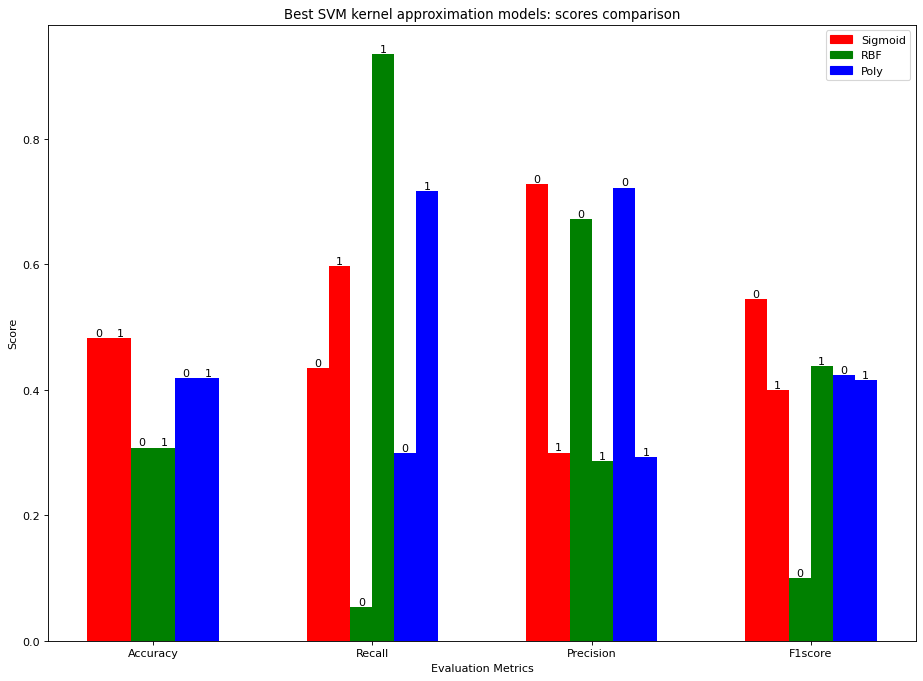

In [ ]:
from matplotlib.patches import Patch
x = np.arange(4)

sigmoid_0 = best_model_df.iloc[0,2:6].values
sigmoid_1 = best_model_df.iloc[1,2:6].values
rbf_0 = best_model_df.iloc[2,2:6].values
rbf_1 = best_model_df.iloc[3,2:6].values
poly_0 = best_model_df.iloc[4,2:6].values
poly_1 = best_model_df.iloc[5,2:6].values

width = 0.1
figure(figsize=(14, 10), dpi=80)

bars1 = plt.bar(x, sigmoid_0, width, color='red')
bars2 = plt.bar(x + 0.1, sigmoid_1, width, color='red')
bars3 = plt.bar(x + 0.2, rbf_0, width, color='green')
bars4 = plt.bar(x + 0.3, rbf_1, width, color='green')
bars5 = plt.bar(x + 0.4, poly_0, width, color='blue')
bars6 = plt.bar(x + 0.5, poly_1, width, color='blue')

plt.xticks(x+0.25, ['Accuracy', 'Recall', 'Precision', 'F1score'])
plt.xlabel("Evaluation Metrics")
plt.ylabel("Score")
plt.title("Best SVM kernel approximation models: scores comparison")

custom_handles = [Patch(color='red', label='Sigmoid'),
                  Patch(color='green', label='RBF'),
                  Patch(color='blue', label='Poly')]

plt.legend(handles=custom_handles)

# Adding class labels to each bar
def add_labels(bars, labels):
    for bar, label in zip(bars, labels):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, label, ha='center', va='bottom')

add_labels(bars1, [0] * len(bars1))
add_labels(bars2, [1] * len(bars2))
add_labels(bars3, [0] * len(bars3))
add_labels(bars4, [1] * len(bars4))
add_labels(bars5, [0] * len(bars5))
add_labels(bars6, [1] * len(bars6))

plt.show()

It is a close decision between our best models. While our rbf best model has exceptional recall for our positive class, the recall for our negative class is very low. You can see this reflected in the accuracy score. Our polynomial model as the recall is slightly higher for our positive class and there is only a marginal drop-off with the precision, when combared to the sigmoid model.

### Evaluating metrics for selected best SVM kernel approximation models <br>
*Undersampling only*

In [ ]:
under_sampler = RandomUnderSampler(random_state=123)
X_under, y_under = under_sampler.fit_resample(X, y)

In [ ]:
y_under.value_counts()

Churn
0    14710
1    14710
Name: count, dtype: int64

In [ ]:
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(\
    X_under, y_under, test_size=0.2, random_state=123, shuffle=True)

In [ ]:
# rbf best model - have to modify number of components to match X train
nystroem_under = Nystroem(kernel='rbf', n_components=500, gamma=2)
sgd_under = SGDClassifier(loss='modified_huber', max_iter=2000, alpha=0.0001, penalty='l2')
# modifed_huber loss function is a smooth loss that brings tolerance to outliers as well as probability estimates.
X_train_under_transformed = nystroem_under.fit_transform(X_train_under)
X_test_under_transformed = nystroem_under.fit_transform(X_test_under)

sgd_under.fit(X_train_under_transformed, y_train_under)
sgd_y_under_preds = sgd_under.predict(X_test_under_transformed)

In [ ]:
evaluate_metrics(y_test_under, sgd_y_under_preds)

{'accuracy': 0.504418762746431,
 'recall': array([0.086868  , 0.92339122]),
 'precision': array([0.53222453, 0.50194336]),
 'f1score': array([0.14935823, 0.65035971])}

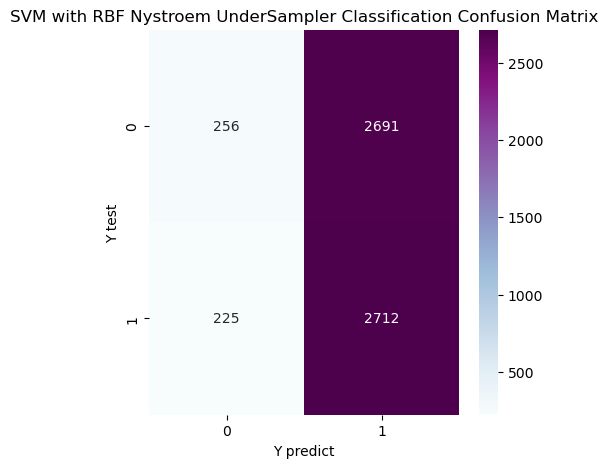

In [ ]:
get_confusion_matrix(y_test_under, sgd_y_under_preds, 'SVM with RBF Nystroem UnderSampler Classification Confusion Matrix')

As we can see, once we perform some resampling technique to reduce the weight of our majority negative class, our recall, precision and f1score improves greatly. Again, we would rather over-estimate the number of customers who are going to churn `Class = 1`, as opposed to over-estimating the number of customers who are not going to churn `Class = 0`. Similar to our best random forest model, the next steps would be to improve the precision score. Perhaps we could attempt a Linear SVM analysis instead.

In [ ]:
# polynomial best model - have to modify number of compnents to match X train
nystroem_under_poly = Nystroem(kernel='poly', n_components=500, gamma=0.5, degree=4)
sgd_under_poly = SGDClassifier(loss='modified_huber', max_iter=2000, alpha=0.0001, penalty='l2')
# modifed_huber loss function is a smooth loss that brings tolerance to outliers as well as probability estimates.
X_train_under_transformed_p = nystroem_under_poly.fit_transform(X_train_under)
X_test_under_transformed_p = nystroem_under_poly.fit_transform(X_test_under)

sgd_under_poly.fit(X_train_under_transformed_p, y_train_under)
sgd_y_under_preds_p = sgd_under_poly.predict(X_test_under_transformed_p)

In [ ]:
evaluate_metrics(y_test_under, sgd_y_under_preds_p)

{'accuracy': 0.5175050985723997,
 'recall': array([0.47438073, 0.5607763 ]),
 'precision': array([0.52008929, 0.51533166]),
 'f1score': array([0.49618456, 0.53709441])}

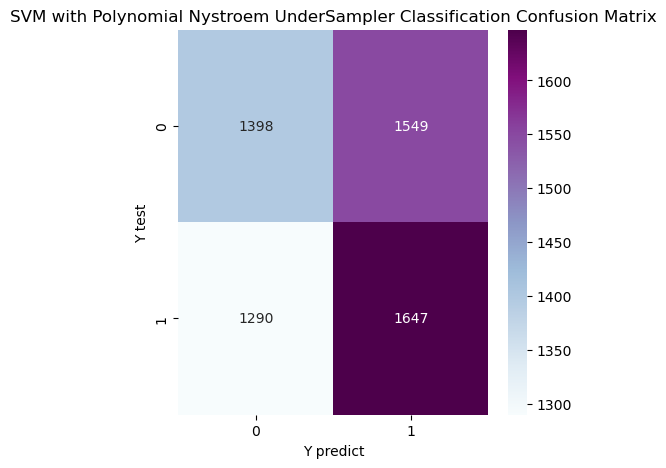

In [ ]:
get_confusion_matrix(y_test_under, sgd_y_under_preds_p, 'SVM with Polynomial Nystroem UnderSampler Classification Confusion Matrix')

With our polynomial model we have about 50% accuracy and recall for both classes. In order to improve this model, we would need to experiment with other different parameters and/or redesign the dataset. Perhaps we could re-do the feature engineering.

---

## Logistic Regression

Our original dataset has high prevalence of outliers. Typically, Logistic Regression models are very sensitive to **outliers**. This is for a number of reasons:
* **Impact on the cost fucntion** - Logistic regression optimizes the log-likelihood or a related cost function, which can be significantly affected by outliers. Outliers can disproportionately affect the gradient descent process, leading to suboptimal model parameters.
* **Influence on linear decision boundary** - Logistic regression models a linear relationship between the independent variables and the log-odds of the dependent variable. Outliers can skew this linear relationship, leading to a misplacement of the decision boundary. This can result in poor classification performance, especially if the outliers are extreme and not representative of the majority of the data.
* **Effect on model coefficients** - Outliers can exert a disproportionate influence on the estimation of model coefficients. Because logistic regression relies on maximizing the likelihood function, outliers can heavily influence the coefficients, making the model less generalizable and increasing the risk of overfitting to noise rather than capturing the underlying pattern.

That said, in this project we have already taken steps to mitigate the impact of outliers in our ML analysis. We have already performd `feature engineering` and `robust scaling` on our dataset.<br>
We will also experiment with different regularization terms (L1,L2,Elastic Net) which can help prevent overfitting to outliers by penalizing large coefficients.

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
df = pd.read_pickle("churn dataset transformed.pkl")
X = df.drop('Churn', axis=1)
y = df['Churn']

In [ ]:
# split the data into train and test splits using StratifiedShuffleSplit to maintain the same ratio of predictor classes
from sklearn.model_selection import StratifiedShuffleSplit
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=123)
train_idx, test_idx = next(strat_split.split(X, y))

# Create the dataframes
X_train = df.loc[train_idx, X.columns]
y_train = df.loc[train_idx, 'Churn']

X_test  = df.loc[test_idx, X.columns]
y_test  = df.loc[test_idx, 'Churn']

In [ ]:
y_train.value_counts(normalize=True)

Churn
0    0.711827
1    0.288173
Name: proportion, dtype: float64

In [ ]:
y_test.value_counts(normalize=True)

Churn
0    0.711832
1    0.288168
Name: proportion, dtype: float64

Our Y train and Y test now have similar distributions.

Grid search for regular logistic regression, L1, L2 and elastic net.

In [ ]:
def evaluate_metrics(yt, yp):
    results_pos = {}
    results_pos['accuracy'] = accuracy_score(yt, yp)
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp)
    results_pos['recall'] = recall
    results_pos['precision'] = precision
    results_pos['f1score'] = f_beta
    return results_pos

#### Basic Logistic Regression - no regularisation

In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [ ]:
lr_model = LogisticRegression(class_weight='balanced', multi_class='ovr', max_iter=1000, solver='saga', random_state=123)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)
lr_results = evaluate_metrics(y_test, lr_preds)
lr_results

c:\Users\User\miniconda3\envs\snowflakes\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



{'accuracy': 0.5822123547081103,
 'recall': array([0.57508485, 0.59981872]),
 'precision': array([0.78021157, 0.36364885]),
 'f1score': array([0.66212505, 0.45278823])}

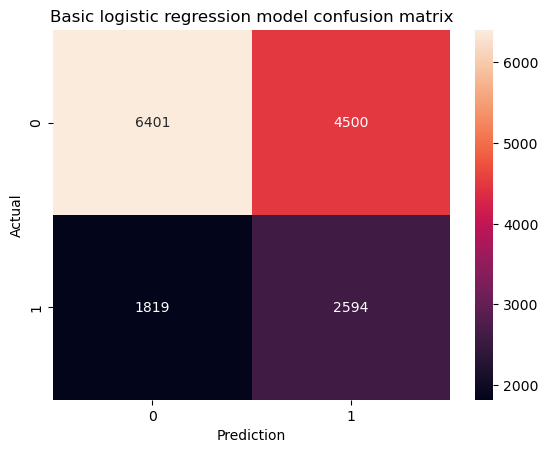

In [ ]:
sns.heatmap(confusion_matrix(y_test, lr_preds), annot=True, fmt='d')
plt.title('Basic logistic regression model confusion matrix')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

In [ ]:
lr_df = pd.DataFrame.from_dict(lr_results).reset_index()
lr_df.loc[0,'index'] = 'lr_basic_0'
lr_df.loc[1,'index'] = 'lr_basic_1'
lr_df_all = lr_df.copy()
lr_df_all

,index,accuracy,recall,precision,f1score
0,lr_basic_0,0.582212,0.575085,0.780212,0.662125
1,lr_basic_1,0.582212,0.599819,0.363649,0.452788


As we can see, we have a similar story with our basic logistic regression model where the majority of our error occurs from false positives. We will see if we can reduce the error rate by adding some **regularisation**.

#### Logistic Regression with L2 (Ridge) Regularisation

In [ ]:
param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'multi_class': ['ovr','multinomial']
}
grid_search = GridSearchCV(LogisticRegression(class_weight='balanced', n_jobs=-1,\
                                              penalty='l2'), param_grid, cv=3, scoring='precision')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced', n_jobs=-1),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'multi_class': ['ovr', 'multinomial']},
             scoring='precision')

In [ ]:
grid_search.best_params_

{'C': 0.01, 'multi_class': 'ovr'}

In [ ]:
lrl2_preds = grid_search.best_estimator_.predict(X_test)
lrl2_results = evaluate_metrics(y_test, lrl2_preds)
lrl2_results

{'accuracy': 0.5931174089068826,
 'recall': array([0.60086231, 0.57398595]),
 'precision': array([0.77698695, 0.36795468]),
 'f1score': array([0.67766799, 0.44843764])}

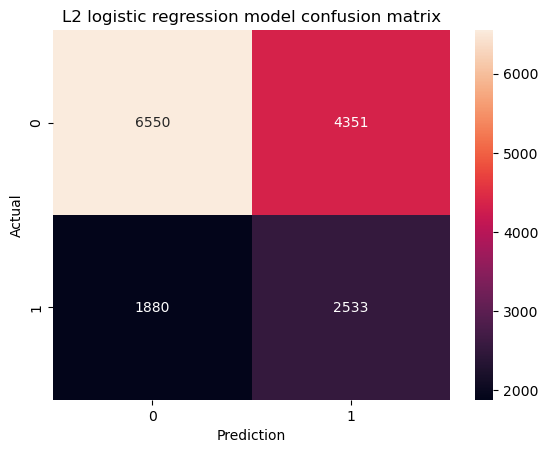

In [ ]:
sns.heatmap(confusion_matrix(y_test, lrl2_preds), annot=True, fmt='d')
plt.title('L2 logistic regression model confusion matrix')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

In [ ]:
lrl2_df = pd.DataFrame.from_dict(lrl2_results).reset_index()
lrl2_df.loc[0,'index'] = 'lrl2_0'
lrl2_df.loc[1,'index'] = 'lrl2_1'
lr_df_all = pd.concat([lr_df_all, lrl2_df], axis=0)
lr_df_all

,index,accuracy,recall,precision,f1score
0,lr_basic_0,0.582212,0.575085,0.780212,0.662125
1,lr_basic_1,0.582212,0.599819,0.363649,0.452788
0,lrl2_0,0.593117,0.600862,0.776987,0.677668
1,lrl2_1,0.593117,0.573986,0.367955,0.448438


When we look at the results for our best ridge model, we notice not too much difference from our basic logistic regression model. That might be because l2 is not strong enough in how it only penalizes large coefficients by reducing them.

#### Logistic Regression with L1 Regularisation

In [ ]:
param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'solver':['liblinear', 'saga']
    #'multi_class': ['ovr','multinomial']  not permitted with L1 regularisation
}
grid_search = GridSearchCV(LogisticRegression(class_weight='balanced',\
                                              penalty='l1'), param_grid, cv=3, scoring='f1')
grid_search.fit(X_train, y_train)

c:\Users\User\miniconda3\envs\snowflakes\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\User\miniconda3\envs\snowflakes\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\User\miniconda3\envs\snowflakes\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\User\miniconda3\envs\snowflakes\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\User\miniconda3\envs\snowflakes\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\User\miniconda3\envs\snowflakes\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceW

GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          penalty='l1'),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'solver': ['liblinear', 'saga']},
             scoring='f1')

In [ ]:
grid_search.best_estimator_

LogisticRegression(C=0.1, class_weight='balanced', penalty='l1', solver='saga')

In [ ]:
lrl1_preds = grid_search.best_estimator_.predict(X_test)
lrl1_results = evaluate_metrics(y_test, lrl1_preds)
lrl1_results

{'accuracy': 0.5401593313308084,
 'recall': array([0.49454179, 0.65284387]),
 'precision': array([0.77870865, 0.34334406]),
 'f1score': array([0.60491472, 0.45001562])}

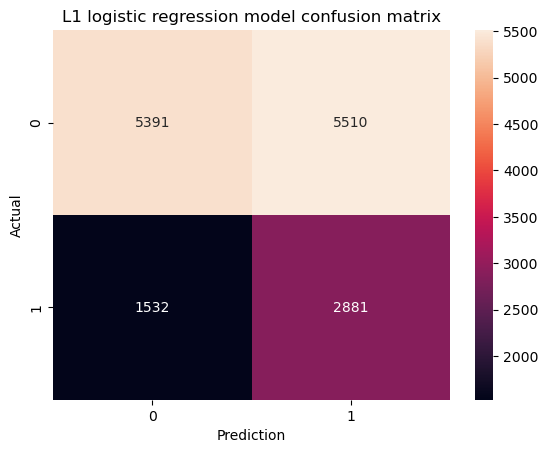

In [ ]:
sns.heatmap(confusion_matrix(y_test, lrl1_preds), annot=True, fmt='d')
plt.title('L1 logistic regression model confusion matrix')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

In [ ]:
lrl1_df = pd.DataFrame.from_dict(lrl1_results).reset_index()
lrl1_df.loc[0,'index'] = 'lrl1_0'
lrl1_df.loc[1,'index'] = 'lrl1_1'
lr_df_all = pd.concat([lr_df_all, lrl1_df], axis=0)
lr_df_all

,index,accuracy,recall,precision,f1score
0,lr_basic_0,0.582212,0.575085,0.780212,0.662125
1,lr_basic_1,0.582212,0.599819,0.363649,0.452788
0,lrl2_0,0.593117,0.600862,0.776987,0.677668
1,lrl2_1,0.593117,0.573986,0.367955,0.448438
0,lrl1_0,0.540159,0.494542,0.778709,0.604915
1,lrl1_1,0.540159,0.652844,0.343344,0.450016


#### Logistic Regression with Elastic Net

In [ ]:
param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'l1_ratio':[0.1, 0.25, 0.5, 0.75, 0.9]
}
grid_search = GridSearchCV(LogisticRegression(class_weight='balanced',solver='saga',n_jobs=-1,\
                                              penalty='elasticnet'), param_grid, cv=3, scoring='f1')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced', n_jobs=-1,
                                          penalty='elasticnet', solver='saga'),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9]},
             scoring='f1')

In [ ]:
grid_search.best_estimator_

LogisticRegression(C=0.1, class_weight='balanced', l1_ratio=0.9, n_jobs=-1,
                   penalty='elasticnet', solver='saga')

In [ ]:
lrelastic_preds = grid_search.best_estimator_.predict(X_test)
lrelastic_results = evaluate_metrics(y_test, lrelastic_preds)
lrelastic_results

{'accuracy': 0.5404858299595142,
 'recall': array([0.49509219, 0.65261727]),
 'precision': array([0.77878788, 0.34351145]),
 'f1score': array([0.60535023, 0.45010549])}

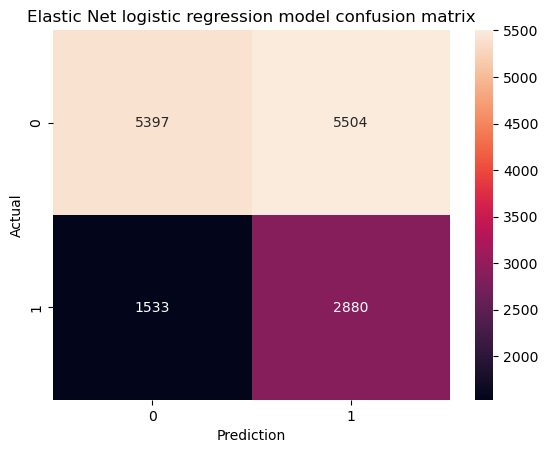

In [ ]:
sns.heatmap(confusion_matrix(y_test, lrelastic_preds), annot=True, fmt='d')
plt.title('Elastic Net logistic regression model confusion matrix')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

In [ ]:
lrelastic_df = pd.DataFrame.from_dict(lrelastic_results).reset_index()
lrelastic_df.loc[0,'index'] = 'lrelastic_0'
lrelastic_df.loc[1,'index'] = 'lrelastic_1'
lr_df_all = pd.concat([lr_df_all, lrelastic_df], axis=0)
lr_df_all

,index,accuracy,recall,precision,f1score
0,lr_basic_0,0.582212,0.575085,0.780212,0.662125
1,lr_basic_1,0.582212,0.599819,0.363649,0.452788
0,lrl2_0,0.593117,0.600862,0.776987,0.677668
1,lrl2_1,0.593117,0.573986,0.367955,0.448438
0,lrl1_0,0.540159,0.494542,0.778709,0.604915
1,lrl1_1,0.540159,0.652844,0.343344,0.450016
0,lrelastic_0,0.540486,0.495092,0.778788,0.605350
1,lrelastic_1,0.540486,0.652617,0.343511,0.450105


Both the more aggressive regularization terms L1 and elastic net failed to improve our scores. There is also a consistent theme of the minority class showing a really low precision score. This might be because we have already performed some significant **feature engineering** on the dataset. Therefore our regularization terms don't have much work to do in shringking/removing coefficients. Let's resample our dataset and re-run the regularised logistic regression models using the best models from each grid search.

#### Resampling - SMOTE

In [ ]:
smote_sampler = SMOTE(random_state=123)
X_smo, y_smo = smote_sampler.fit_resample(X_train, y_train)

In [ ]:
y_smo.value_counts()

Churn
0    25435
1    25435
Name: count, dtype: int64

In [ ]:
lrl1_best_model = LogisticRegression(C=0.1, class_weight='balanced', penalty='l1', solver='saga')
lrl1_best_model.fit(X_smo, y_smo)
lrl1_smote_preds = lrl1_best_model.predict(X_test)
evaluate_metrics(y_test, lrl1_smote_preds)

{'accuracy': 0.5498889904662401,
 'recall': array([0.51683332, 0.63154317]),
 'precision': array([0.77603306, 0.34603924]),
 'f1score': array([0.62045042, 0.44710034])}

In [ ]:
lr_elastic_best_model = LogisticRegression(C=0.1, class_weight='balanced', l1_ratio=0.9, n_jobs=-1,\
                   penalty='elasticnet', solver='saga')
lr_elastic_best_model.fit(X_smo, y_smo)
lr_elastic_smote_preds = lr_elastic_best_model.predict(X_test)
evaluate_metrics(y_test, lr_elastic_smote_preds)

{'accuracy': 0.5500848896434635,
 'recall': array([0.51710852, 0.63154317]),
 'precision': array([0.77612557, 0.34616818]),
 'f1score': array([0.62067826, 0.44720796])}

Unfortunately, resampling our dataset didn't improve the precision of our minority class `class = 1`. In the next iteration of this project, we would have to experiment with different techniques to improve this.

---

### Choosing our Best Model

All three models performed similarly in showing high recall but fairly low precision. The pattern is an over-predicting over the positive class. Even though this mis more preferable than over-stating the negative class, we would need to imporve the precision before productionising any model for predicting customer churn.<br>
Nevertheless, our selected model for this iteration would be our selected **Random Forest** model which was with **class re-weighting**. Some techniques we could try to improve the *precision* of our random forest model would be the following:

Increase max_depth: Allow the trees to grow deeper to capture more complex patterns.
Adjust n_estimators: Increase the number of trees in the forest to improve model stability and performance.
Change max_features: Experiment with different values such as sqrt, a fixed number, or a fraction of features.
Adjust min_samples_split and min_samples_leaf: Try different values to prevent overfitting and ensure that leaves are sufficiently populated.
Adjust class_weight: Fine-tune the class weights to better handle class imbalance.

Create New Features: Derive new features from existing data that might provide better predictive power.
Feature Selection: Use techniques like recursive feature elimination (RFE) or feature importance from the model to select the most relevant features.
Handle Categorical Variables: Ensure categorical variables are properly encoded using techniques like one-hot encoding or ordinal encoding.
Data Preprocessing:

Handle Missing Values: Properly impute or remove missing values.
Scale Features: Although Random Forests are less sensitive to feature scaling, scaling can still sometimes help.
Balance Classes: Use techniques like SMOTE (Synthetic Minority Over-sampling Technique) to balance classes.
Model Ensemble:

Ensemble Different Models: Combine Random Forest with other models like Gradient Boosting, XGBoost, or LightGBM.
Stacking: Use the predictions of several models as input features for a meta-model.
Cross-Validation and Bootstrapping:

Feature Importances: Analyze feature importances from the model to understand which features contribute most to predictions and refine the feature set accordingly.
Partial Dependence Plots (PDP): Use PDPs to understand the relationship between the target and a feature, helping in feature engineering.
Use Probabilistic Predictions: Instead of using a hard threshold (0.5) for classification, experiment with different probability thresholds to improve precision.

---